In [18]:
import csv
import numpy as np
import pprint # as pp
import operator
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

class FormatPrinter(pprint.PrettyPrinter):

    def __init__(self, formats):
        super(FormatPrinter, self).__init__()
        self.formats = formats

    def format(self, obj, ctx, maxlvl, lvl):
        if type(obj) in self.formats:
            return self.formats[type(obj)] % obj, 1, 0
        return pprint.PrettyPrinter.format(self, obj, ctx, maxlvl, lvl)

fp = FormatPrinter({float: "%0.2f", int: "%d"})

files = ['/Users/matt/Downloads/logs/2020-12-12-first_chaos_full.csv',
        '/Users/matt/Downloads/logs/logs2/votes-2020-12-15_04-47-04.csv',
        '/Users/matt/Downloads/logs/logs3/votes-2020-12-17_03-44-07.log']
allVotes = []
allNames = []

for file in files:
    #with open('/Users/matt/Downloads/logs/2020-12-12-first_chaos_full.csv', newline='') as csvfile:
    #with open('/Users/matt/Downloads/logs/logs2/votes-2020-12-15_04-47-04.csv', newline='') as csvfile:
    #with open('/Users/matt/Downloads/logs/logs3/votes-2020-12-17_03-44-07.log', newline='') as csvfile:
    with open(file, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        
        for row in spamreader:
            row.pop(6)
            rowNames = row[::2]
            for i in range(len(rowNames)):
                if rowNames[i] == "Disco":
                    #print("replacing: " + rowNames[i])
                    rowNames[i] = 'Anthony Caliber'
                    #print("New name: " + rowNames[i])
            
            #names = np.array(row[::2])
            names = np.array(rowNames)
            votes = np.array(row[1::2]).astype(int)
        
            indices = votes[::-1].argsort()
            names = names[::-1][indices]
            votes = votes[::-1][indices]
            #fp.pprint(names)
            if votes.sum() > 0:
                allVotes.append(votes)
                allNames.append(names)
                percentages = votes.astype(float)/float(votes.sum())*100.0
            else:
                percentages = votes.astype(float)*100.0
            #print(names)
            #print(indices)
            #print(sortedNames)
            #print(sortedVotes)
            #print(percentages)
   
voteData = {}
for i in range(len(allNames)):
    for k in range(len(allNames[i])):
        key = allNames[i][k] #.replace(\" \",\"\").replace(\"/\",\"\")
        #print(key)
        if not key in voteData:
            voteData[key] = {}
            voteData[key]['totalVotes'] = 0
            voteData[key]['totalWins'] = 0
            voteData[key]['totalLosses'] = 0
            voteData[key]['totalLast'] = 0
            voteData[key]['totalAppearances'] = 0
            voteData[key]['lostTo'] = {}
            voteData[key]['averagePercentage'] = 0 # TODO

        voteData[key]['totalVotes'] += allVotes[i][k]
            
for key in voteData:
    for votingRound in allNames:
        if key in votingRound:
            voteData[key]['totalAppearances'] += 1
            if key == votingRound[0]:
                voteData[key]['totalLast'] += 1
                
            winningVote = votingRound[len(votingRound)-1]
            if key == winningVote:
                voteData[key]['totalWins'] += 1
            else:
                voteData[key]['totalLosses'] += 1
                if not winningVote in voteData[key]['lostTo']:
                    voteData[key]['lostTo'][winningVote] = 0
                voteData[key]['lostTo'][winningVote] += 1
  
for key in voteData:
    voteData[key]['Win Percentage'] = voteData[key]['totalWins']/voteData[key]['totalAppearances']*100
    voteData[key]['Loss Percentage'] = voteData[key]['totalLosses']/voteData[key]['totalAppearances']*100
    voteData[key]['Last Percentage'] = voteData[key]['totalLast']/voteData[key]['totalAppearances']*100
    voteData[key]['Popularity'] = voteData[key]['totalVotes']/voteData[key]['totalAppearances']
#pp.pprint(voteData)
    
def getHighestByKey(voteData, key, total, reverse=False):
    sortedWins = list({k: v for k, v in sorted(voteData.items(), key=lambda item: item[1][key], reverse=reverse)})
    top = []
    for i in range(len(sortedWins)-total,len(sortedWins)):
        top.append( (sortedWins[i], voteData[sortedWins[i]][key]) )
    return top
    

In [15]:
print("Total Options that Appeared: " + str(len(voteData.keys())))
print("Total Modifiers Activated: " + str(len(allVotes)))

totalVotes = []
for i in range(len(allVotes)):
    totalVotes.append(sum(allVotes[i]))
print("Average Votes/Round: %0.2f" % (sum(totalVotes)/len(totalVotes)))

index = np.argmax(np.array(totalVotes), axis=0)
print("Most Voted Round Results:")
for i in range(len(allVotes[index])):
    print("%2d: %s" % (allVotes[index][i], allNames[index][i]))

Total Options that Appeared: 95
Total Modifiers Activated: 1141
Average Votes/Round: 6.19
Most Voted Round Results:
 1: Swap Joysticks
 1: Inverted
10: Mirror World


<Figure size 720x144 with 0 Axes>

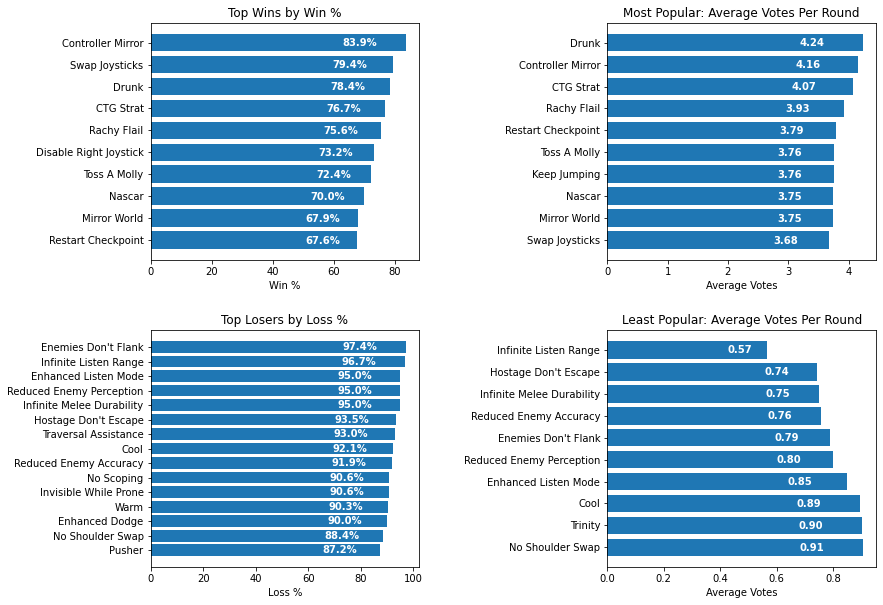

In [19]:
plt.figure(figsize=(10,2))
#fp.pprint(topWins)
fig,a =  plt.subplots(2,2,figsize=(13,10))
#fig.tight_layout()
plt.subplots_adjust(wspace = 0.7, hspace = 0.3)

topWins = getHighestByKey(voteData, 'Win Percentage', 10, reverse=False)
names = [x[0] for x in topWins]
percent = [x[1] for x in topWins]
a[0][0].barh( names, percent)
a[0][0].set_title("Top Wins by Win %")
a[0][0].set_xlabel('Win %')
#a[0][0].set_ylabel('Mods')
#plt.show()
for i, v in enumerate(percent):
    a[0][0].text(v *0.75 , i -0.16, "%0.1f%%" % (v), color='White', fontweight='bold')

topLasts = getHighestByKey(voteData, 'Loss Percentage', 15)
names = [x[0] for x in topLasts]
percent = [x[1] for x in topLasts]
a[1][0].barh( names, percent)
a[1][0].set_title("Top Losers by Loss %")
a[1][0].set_xlabel('Loss %')
#a[1][0].set_ylabel('Mods')
for i, v in enumerate(percent):
    a[1][0].text(v*0.75 , i -0.21, "%0.1f%%" % (v), color='White', fontweight='bold')
#plt.show()

topVotes = getHighestByKey(voteData, 'Popularity', 10, reverse=False)
names = [x[0] for x in topVotes]
percent = [x[1] for x in topVotes]
a[0][1].barh( names, percent)
a[0][1].set_title("Most Popular: Average Votes Per Round")
a[0][1].set_xlabel('Average Votes')
#a[0][1].set_ylabel('Mods')
for i, v in enumerate(percent):
    a[0][1].text(v *0.75 , i -0.16, "%0.2f" % (v), color='White', fontweight='bold')
    
topVotes = getHighestByKey(voteData, 'Popularity', 10, reverse=True)
names = [x[0] for x in topVotes]
percent = [x[1] for x in topVotes]
a[1][1].barh( names, percent)
a[1][1].set_title("Least Popular: Average Votes Per Round")
a[1][1].set_xlabel('Average Votes')
#a[0][1].set_ylabel('Mods')
for i, v in enumerate(percent):
    a[1][1].text(v *0.75 , i -0.16, "%0.2f" % (v), color='White', fontweight='bold')
    
plt.show()

In [20]:
fp.pprint( voteData )

{'1960': {'Last Percentage': 41.67,
          'Loss Percentage': 72.22,
          'Popularity': 1.8055555555555556,
          'Win Percentage': 27.78,
          'averagePercentage': 0,
          'lostTo': {'4-Bit Audio': 1,
                     '8-Bit Audio': 1,
                     'Blacklight': 1,
                     'Disable Right Joystick': 1,
                     'Dungeon': 1,
                     'Force Prone': 1,
                     'Force Running': 2,
                     'High Contrast Display': 1,
                     'Infinite Breath': 1,
                     'Inverted': 1,
                     'Keep Jumping': 1,
                     'Nascar': 1,
                     'No Aiming': 2,
                     'No Reloading': 1,
                     'No Throwables': 1,
                     'No Triangle': 1,
                     'Noir': 2,
                     'Pdub It': 3,
                     'Restart Checkpoint': 1,
                     'Toss A Molly': 1,
                     '

                        'Nascar': 1,
                        'No Melee': 1,
                        'No Reloading': 1,
                        'Only Strafe Movement': 1,
                        'Periodic Listen Mode': 1,
                        'Rachy Flail': 2,
                        'Swap Joysticks': 1,
                        'Toss A Molly': 2,
                        'Touch Of Death': 1,
                        'Water Color': 1},
             'totalAppearances': 33,
             'totalLast': 18,
             'totalLosses': 26,
             'totalVotes': 44,
             'totalWins': 7},
 "Enemies Don't Flank": {'Last Percentage': 55.26,
                         'Loss Percentage': 97.37,
                         'Popularity': 0.7894736842105263,
                         'Win Percentage': 2.63,
                         'averagePercentage': 0,
                         'lostTo': {'4-Bit Audio': 1,
                                    '8-Bit': 1,
                                    'Ant

                  'averagePercentage': 0,
                  'lostTo': {'Anthony Caliber': 1,
                             'CTG Strat': 1,
                             'Desk Pop': 1,
                             'Force Prone': 1,
                             'Keep Jumping': 1,
                             'Nascar': 1,
                             'No Aiming': 1,
                             'No Guns': 1,
                             'No Throwables': 1,
                             'Pop Poster': 1,
                             'Swap Joysticks': 1,
                             'Touch Of Death': 1},
                  'totalAppearances': 36,
                  'totalLast': 6,
                  'totalLosses': 12,
                  'totalVotes': 113,
                  'totalWins': 24},
 'Keep Jumping': {'Last Percentage': 10.81,
                  'Loss Percentage': 32.43,
                  'Popularity': 3.7567567567567566,
                  'Win Percentage': 67.57,
                  'averagePe

                         'No Climbing/Jumping': 1,
                         'No Crouch/Prone': 1,
                         'No Guns': 1,
                         'No Melee': 1,
                         'No Reloading': 1,
                         'No Triangle': 2,
                         'Pusher': 1,
                         'Reduced Enemy Accuracy': 1,
                         'Swap Joysticks': 1,
                         'Terminated': 1,
                         'Xenon Audio': 1},
              'totalAppearances': 36,
              'totalLast': 11,
              'totalLosses': 28,
              'totalVotes': 66,
              'totalWins': 8},
 'Only Strafe Movement': {'Last Percentage': 23.33,
                          'Loss Percentage': 40.00,
                          'Popularity': 3.033333333333333,
                          'Win Percentage': 60.00,
                          'averagePercentage': 0,
                          'lostTo': {'Beasts': 1,
                                 

                     'No Reloading': 1,
                     'No Throwables': 1,
                     'Periodic Listen Mode': 1,
                     'Pop Poster': 1,
                     'Rachy Flail': 1,
                     'Slow Motion': 2,
                     'Void': 1},
          'totalAppearances': 31,
          'totalLast': 15,
          'totalLosses': 28,
          'totalVotes': 33,
          'totalWins': 3},
 'Water Color': {'Last Percentage': 45.00,
                 'Loss Percentage': 85.00,
                 'Popularity': 1.225,
                 'Win Percentage': 15.00,
                 'averagePercentage': 0,
                 'lostTo': {'8-Bit': 1,
                            'Controller Mirror': 2,
                            'Disable Right Joystick': 4,
                            'Drunk': 1,
                            'Force Prone': 1,
                            'Force Running': 1,
                            'Headache': 2,
                            'Helium Audio': 

In [22]:
fp.pprint( voteData['Rachy Flail'] )


{'Last Percentage': 7.32,
 'Loss Percentage': 24.39,
 'Popularity': 3.926829268292683,
 'Win Percentage': 75.61,
 'averagePercentage': 0,
 'lostTo': {'CTG Strat': 1,
            'Disable Right Joystick': 1,
            'High Contrast Display': 1,
            'Infinite Crafting': 1,
            'Inverted': 1,
            'Keep Dodging': 1,
            'Mega Scope Sway': 1,
            'Melee Only': 1,
            'Nascar': 1,
            'Pdub It': 1},
 'totalAppearances': 41,
 'totalLast': 3,
 'totalLosses': 10,
 'totalVotes': 161,
 'totalWins': 31}
